# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Environment/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### 4.1 Settings

In [7]:
import torch
from ddpg_agent import Agent
from ddpg_result_visualization import plot_scores, format_episode_score
from ddpg_gridsearch import DDPGGridsearch
from collections import deque
from numpy import random

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 4.2 Requirements to solve the environment

In [9]:
moving_avg_size = 100
min_moving_avg_score = 0.5
print(f"Moving average size: {moving_avg_size}")
print(f"Minimum moving average score: {min_moving_avg_score}")

Moving average size: 100
Minimum moving average score: 0.5


### 4.3 Train the Agent with DDPG

In [10]:
def ddpg(agent, n_episodes=1000, max_t=1000, print_every=100, moving_avg_size=100,
         min_moving_avg_score=0.5, min_skip_episodes = 500, skip_score = 0.01):
    
    scores = []
    moving_avg_scores = []
    scores_window = deque(maxlen=moving_avg_size)
    needed_episodes = 0
    best_moving_avg_score = 0
    solved = False
    
    for i_episode in range(1, n_episodes+1):  
        env_info = env.reset(train_mode=True)[brain_name]
        episode_scores = np.zeros(num_agents)                    # initialize the score (for each agent)
        agent.reset()                                            # reset the OUNoise object
        states = env_info.vector_observations             

        for t in range(max_t):    
            action1 =  agent.act(states[0])
            action2 =  agent.act(states[1])
            actions = np.concatenate((action1, action2), axis=0)
            env_info = env.step(actions)[brain_name]             # send actions to the environment
            next_states = env_info.vector_observations           # get next state (for each agent)
            rewards = env_info.rewards                           # get reward (for each agent)
            dones = env_info.local_done                          # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                                 # roll over states to next time step
            
            episode_scores += rewards                            # update the score
            if np.any(dones):                                    # exit loop if episode finished
                break

        
        episode_score = np.max(episode_scores)
        scores.append(episode_score)           
        scores_window.append(episode_score)
        moving_avg_score = np.mean(scores_window)
        moving_avg_scores.append(moving_avg_score)
        
        if moving_avg_score > best_moving_avg_score:
            best_moving_avg_score = moving_avg_score
        
        if (i_episode == min_skip_episodes) and moving_avg_score < skip_score: # skip episode if score is too low
            print(format_episode_score(i_episode, episode_score, moving_avg_score))
            print(f"Episodes skipped\tEnvironment not solved!")
            break
        
        if i_episode % print_every == 0:
            print(format_episode_score(i_episode, episode_score, moving_avg_score))
        
        if (i_episode >= moving_avg_size) and (moving_avg_score >= min_moving_avg_score):
            print(format_episode_score(i_episode, episode_score, moving_avg_score))
            print(f"Environment solved!")
            needed_episodes = i_episode - moving_avg_size
            solved = True
            break
        
        if (i_episode+1 == n_episodes+1) and (moving_avg_score < min_moving_avg_score):
            print(format_episode_score(i_episode, episode_score, moving_avg_score))
            print(f"Environment not solved!")
            
    return scores, moving_avg_scores, best_moving_avg_score, needed_episodes, solved

In [11]:
def save_model_weights(agents=[]):
    for idx, agent in enumerate(agents):
        actor_cp = f"checkpoint_actor_{idx+1}.pth"
        critic_cp = f"checkpoint_critic_{idx+1}.pth"
        torch.save(agent.actor_local.state_dict(), actor_cp)   
        torch.save(agent.critic_local.state_dict(), critic_cp)

In [12]:
gridsearch = DDPGGridsearch()
hyperparameters = gridsearch.create_gridsearch_params() #create a grid search hyperparameters list

print("DDPGGridsearch hyperparameters:")
print(gridsearch)
print()
params_len = len(hyperparameters)

n_episodes = 2500
print_every = 100
max_t = 1000
best_scores = []
best_avg_score = 0
best_moving_avg_scores = []
best_needed_episodes = 0
best_params = None
moving_avg_scores = []

for idx, params in enumerate(hyperparameters): #for every DDPQHyperparameters object 
    print(f"DQNHyperparameters: {idx+1}/{params_len}")
    print(params)
    print()
    agent = Agent(device, params, state_size, action_size)
    
    scores, moving_avg_scores, moving_avg_score, needed_episodes, solved = ddpg(agent=agent, 
                                                    n_episodes=n_episodes, max_t=max_t, 
                                                    print_every=print_every, 
                                                    moving_avg_size=moving_avg_size, 
                                                    min_moving_avg_score=min_moving_avg_score)

    if (moving_avg_score >= best_avg_score): # find the best moving average score
        best_scores = scores
        best_needed_episodes = needed_episodes
        best_avg_score = moving_avg_score
        best_moving_avg_scores = moving_avg_scores
        best_params = params
        save_model_weights([agent])
        
    if solved:
        break
        
    print()
    
print()
print("Best DDPGHyperparameters:")
print(best_params)
print()
print(f"Solved in {best_needed_episodes} episodes.")

DDPGGridsearch hyperparameters:
lr_actor: [0.0015]
lr critic: [0.0015]
gamma: [0.99]
buffer size: [100000]
batch size: [128]
weight decay: [0]
random seed: [1]
fc1 units actor: [300]
fc2 units actor: [200]
fc3 units actor: [100]
fc1 units critic: [200]
fc2 units critic: [100]

DQNHyperparameters: 1/1
lr_actor: 0.0015
lr_critic: 0.0015
gamma: 0.99
buffer_size: 100000
batch_size: 128
tau: 0.003
weight_decay: 0
random_seed: 1
fc1_units actor: 300
fc2_units actor: 200
fc3_units actor: 100
fc1_units critic: 200
fc2_units critic: 100

Episode: 100	Episode score: 0.0900	Moving average score: 0.0183
Episode: 200	Episode score: 0.0000	Moving average score: 0.0206
Episode: 300	Episode score: 0.0000	Moving average score: 0.0048
Episode: 400	Episode score: 0.1000	Moving average score: 0.0430
Episode: 500	Episode score: 0.0000	Moving average score: 0.0236
Episode: 600	Episode score: 0.1000	Moving average score: 0.0747
Episode: 700	Episode score: 0.1000	Moving average score: 0.2028
Episode: 800	Epis

### 4.4 Solution

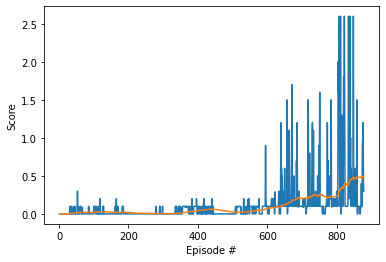

In [13]:
plot_scores(best_scores, best_moving_avg_scores)

The environment was solved with the DDPG algorithm in 778 episodes.

<strong>Model Architecture:</strong><br>
2 Actor networks with 4 linear layers and 1 batch normalization layer:<br>
Linear layer 1: 24 x 300<br>
Batch normalization layer<br>
Linear layer 2: 300 x 200<br>
Linear layer 3: 200 x 100<br>
Linear layer 4: 100 x 2<br>

2 Critic networks with 3 linear layers and 1 batch normalization layer:<br>
Linear layer 1: 24 x 200<br>
Batch normalization layer<br>
Linear layer 2: (200+2) x 100<br>
Linear layer 3: 100 x 1<br>

<strong>Hyperparameters:</strong><br>
Learning rate actor: 0.00015<br>
Learning rate critic: 0.00015<br>
Gamma: 0.99<br>
Buffer size: 100000<br>
Batch size: 128<br>
Tau: 0.003<br>
Weight decay: 0<br>

<strong>Improvement</strong><br>
The model performance could possibly improved by running several 2 agent games in parallel.

### 4.5. Close the environment

In [15]:
env.close()